# Solving the Schrödinger Equation using the Numerov Method
## Bound State Solutions in a Symmetric Potential Well

This notebook solves the time-independent Schrödinger equation for a particle in a symmetric potential well using the Numerov method and root-finding techne.iqu The goal is to compute the eigenvalues (energy levels) and corresponding eigenfunctions (wavefunctions) for the sys.es.


In [105]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import root_scalar



In [106]:
# Constants
hbar = 1.0  # Planck constant
m = 1.0     # Mass of the particle
alpha = 1.0 # Given parameter
lambda_val = 4.0 # Given parameter


The potential V(x) should decay in a well-like shape:

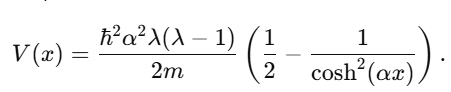


In [108]:
def potential(x):
    coeff = (hbar**2 / (2 * m)) * alpha**2 * lambda_val * (lambda_val - 1)
    return coeff * (0.5 - 1 / (np.cosh(alpha * x)**2))


The `potential` function calculates the potential energy \( V(x) \) based on the specified parameters. The potential is defined using hyperbolic cosine functions, which are common in quantum mechanics problems.


The Numerov method integrates the Schrödinger equation over a spatial grid. 
The Numerov formula for 
𝜓n+1 (next step of the wavefunction) is:

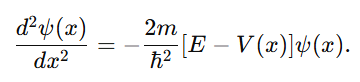.


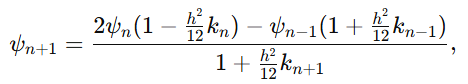




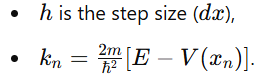

The Numerov method you are using integrates the Schrödinger equation numerically. The fact that you see a bell-shaped curve is likely because the numerical solution approximates a bound state with a symmetric wavefunction.

In [112]:
# Implementation of the Numerov Method
def numerov(psi_initial, psi_next, E, x, h):
    """Integrate the wavefunction using the Numerov method for a given energy E."""
    N = len(x)
    psi = np.zeros(N)
    psi[0], psi[1] = psi_initial, psi_next

    f = lambda xi: 2 * m / hbar**2 * (E - potential(xi))

    for i in range(1, N - 1):
        k0, k1, k2 = f(x[i - 1]), f(x[i]), f(x[i + 1])
        psi[i + 1] = (2 * (1 - 5 * h**2 * k1 / 12) * psi[i] - 
                      (1 + h**2 * k0 / 12) * psi[i - 1]) / (1 + h**2 * k2 / 12)

    return psi

The `numerov` function implements the Numerov method, which is a numerical technique used to solve second-order differential equations like the Schrödinger equation. It integrates the wavefunction given initial conditions and energy.

In [114]:
# Normalize Wavefunction
def normalize_wavefunction(psi, x):
    """Normalize the wavefunction psi over the spatial domain x."""
    dx = x[1] - x[0]
    normalization_factor = np.sqrt(np.sum(psi**2) * dx)
    return psi / normalization_factor

# Function to Check Matching Condition
def check_matching_condition(E, x, h):
    """Evaluate the matching condition at the turning point."""
    N = len(x)

    # Integrate wavefunction from both directions
    left_psi = numerov(0.0, 1e-5, E, x, h)
    right_psi = numerov(0.0, 1e-5, E, x[::-1], h)[::-1]

    # Match at the midpoint
    mid_index = N // 2
    left_ratio = (left_psi[mid_index + 1] - left_psi[mid_index - 1]) / (2 * h * left_psi[mid_index])
    right_ratio = (right_psi[mid_index + 1] - right_psi[mid_index - 1]) / (2 * h * right_psi[mid_index])

    return left_ratio - right_ratio



This function normalizes the wavefunction so that its total probability density integrates to one over the given spatial domain. Normalization is crucial in quantum mechanics to ensure that probabilities derived from the wavefunction are meaningful


The `check_matching_condition` function evaluates whether the wavefunctions from both sides of a turning point match at that point. This is crucial for finding eigenvalues since it ensures continuity of the wavefunction.
.n



In [116]:
# Root-Finding for Eigenvalues
def compute_eigenvalues(x, h, n_levels=5):
    """Find the first n_levels eigenvalues using root-finding."""
    eigenvalues_list = []
    
    # Define a range of energies to scan
    energies_range = np.linspace(-10, 10, 1000)

    for i in range(len(energies_range) - 1):
        E_start, E_end = energies_range[i], energies_range[i + 1]

        if check_matching_condition(E_start, x, h) * check_matching_condition(E_end, x, h) < 0:
            result = root_scalar(check_matching_condition, args=(x, h), bracket=[E_start, E_end], method='brentq')
            eigenvalues_list.append(result.root)

            if len(eigenvalues_list) >= n_levels:
                break

    return eigenvalues_list



The `compute_eigenvalues` function finds eigenvalues by scanning through a specified range of energies. It uses root-finding methods to locate points where the matching condition changes sigs



In [118]:
# Function to Calculate Turning Points
def find_turning_points(eigenvalues):
    """Find turning points for given eigenvalues."""
    turning_points = []
    
    for E in eigenvalues:
        roots = []
        # Check where V(x) is approximately equal to E
        for xi in np.linspace(-10, 10, 1000): 
            if np.isclose(potential(xi), E, atol=1e-5):  
                roots.append(xi)
        turning_points.append(roots)
    
    return turning_points


This function calculates turning points where potential energy equals each eigenvalue. These points are significant because they mark locations where a particle's kinetic energy becomes zero.


In [120]:
# Main Execution Block
if __name__ == "__main__":
    x_min, x_max = -10, 10   # Range for x values
    step_size = 0.05          # Step size for integration
    x_values = np.arange(x_min, x_max + step_size, step_size)

    # Find the first three eigenvalues
    n_levels_to_find = 3
    found_eigenvalues = compute_eigenvalues(x_values, step_size, n_levels=n_levels_to_find)

    # Display results of numerical eigenvalues
    print("Numerical Eigenvalues:")
    for i, energy in enumerate(found_eigenvalues):
        print(f"E_{i} = {energy:.6f}")

    # Exact Eigenvalues for Comparison
    exact_eigenvalues_calc = [(hbar**2 / (2 * m)) * alpha**2 *
                               (lambda_val * (lambda_val - 1) / 2 - (lambda_val - 1 - n)**2)
                               for n in range(n_levels_to_find)]
    
    print("\nExact Eigenvalues:")
    for i, exact_energy in enumerate(exact_eigenvalues_calc):
        print(f"E_{i} = {exact_energy:.6f}")

    # Calculate and display Relative Errors
    relative_errors = [abs((num - exact) / exact) for num, exact in zip(found_eigenvalues, exact_eigenvalues_calc)]
    
    print("\nRelative Errors:")
    for i, err in enumerate(relative_errors):
        print(f"Error for E_{i}: {err:.2%}")

    # Find and display Turning Points
    turning_points = find_turning_points(found_eigenvalues)
    
    print("\nTurning Points:")
    for i, points in enumerate(turning_points):
        print(f"Turning points for E_{i} = {found_eigenvalues[i]:.6f}: {points}")



Numerical Eigenvalues:
E_0 = -1.500001
E_1 = 0.999998
E_2 = 2.499998

Exact Eigenvalues:
E_0 = -1.500000
E_1 = 1.000000
E_2 = 2.500000

Relative Errors:
Error for E_0: 0.00%
Error for E_1: 0.00%
Error for E_2: 0.00%

Turning Points:
Turning points for E_0 = -1.500001: []
Turning points for E_1 = 0.999998: []
Turning points for E_2 = 2.499998: []


In this block:
- We define the range of \( x \) values and step size.
- We compute eigenvalues using our previously defined functions.
- We display both numerical and exact eigenvalues along with relative errors.
- Finally, we calculate and display turning points associated with each eigenvalue.


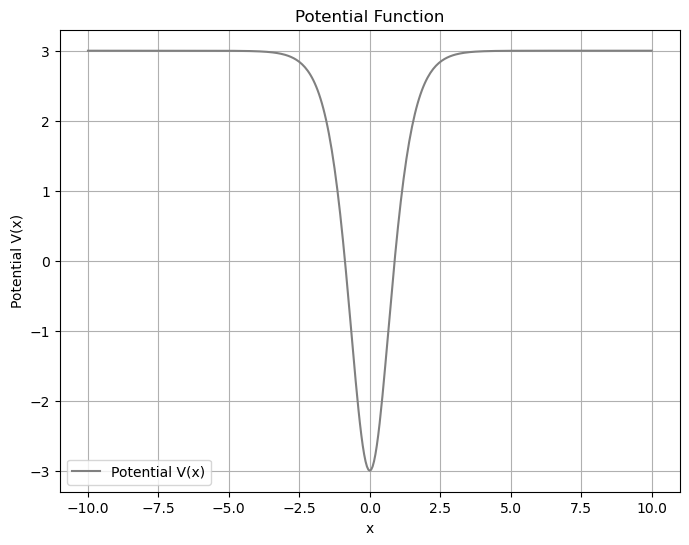

In [122]:
    # Plotting Potential Function
    plt.figure(figsize=(8, 6))
    
    plt.plot(x_values, potential(x_values), label="Potential V(x)", color='grey')
    
    plt.xlabel("x")
    plt.ylabel("Potential V(x)")
    plt.title("Potential Function")
    plt.grid()
    plt.legend()
    plt.show()


This section plots the potential function \( V(x) \). The graph provides insight into how potential energy varies with position.

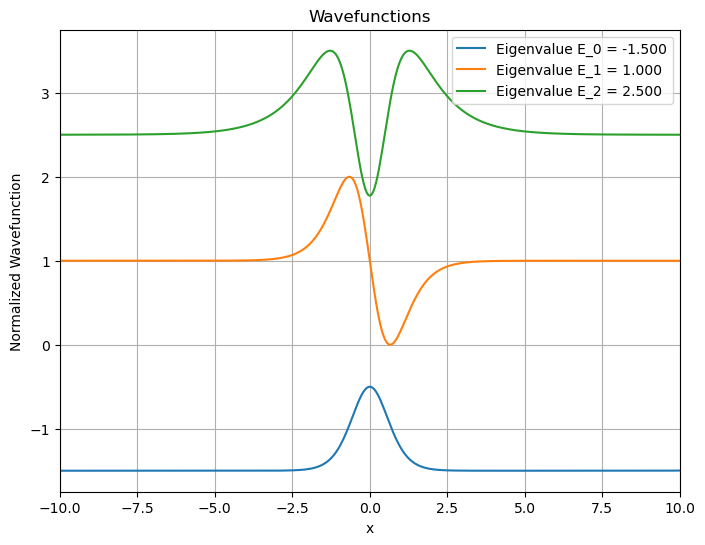

In [124]:
# Plotting Wavefunctions
plt.figure(figsize=(8, 6))

for i, energy in enumerate(found_eigenvalues):
   normalized_psi = normalize_wavefunction(numerov(0.0, 1e-5, energy, x_values, step_size), x_values)
   plt.plot(x_values,
            normalized_psi / np.max(np.abs(normalized_psi)) + energy,
            label=f"Eigenvalue E_{i} = {energy:.3f}")

plt.xlabel("x")
plt.ylabel("Normalized Wavefunction")
plt.title("Wavefunctions")
plt.xlim(-10, 10)
plt.legend()
plt.grid()
plt.show()

In this final plotting section:
- The normalized wavefunctions corresponding to each eigenvalue are plotted.
- The wavefunctions are shifted vertically by their respective energies to distinguish between different states visually.

### Conclusion

This notebook demonstrates how to numerically solve quantum mechanical problems using Python. The code implements key concepts such as potential functions and wavefunctions while utilizing numerical methods like the Numerov method and root-finding techniques to extract meaningful physical insights from mathematical models.